# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.70,0.15,0.15))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [01:24, 50.32 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 162 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 166 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 154 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 158 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 751 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 769 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 711 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 733 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 161 images in './outputgrayscale/

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [ ]:
epoch = 20
batchsize = 16

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [ ]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 0s 0us/step


In [ ]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                             

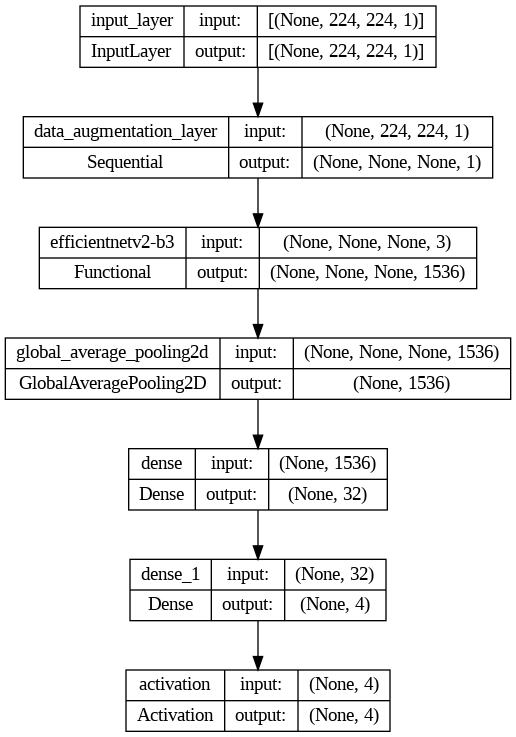

In [ ]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [ ]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 73s 288ms/step - loss: 0.7150 - accuracy: 0.7055 - val_loss: 0.7150 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 43s 230ms/step - loss: 0.5893 - accuracy: 0.7665 - val_loss: 0.6983 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 37s 196ms/step - loss: 0.5362 - accuracy: 0.7922 - val_loss: 0.5972 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 36s 195ms/step - loss: 0.4950 - accuracy: 0.8070 - val_loss: 0.5945 - val_accuracy: 0.7744 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 34s 182ms/step - loss: 0.5030 - accuracy: 0.8013 - val_loss: 0.6563 - val_accuracy: 0.7539 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 30s 159ms/step - loss: 0.4818 - accuracy: 0.8124 - val_loss: 0.5849 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

EfficientNetV2B3 Evaluation

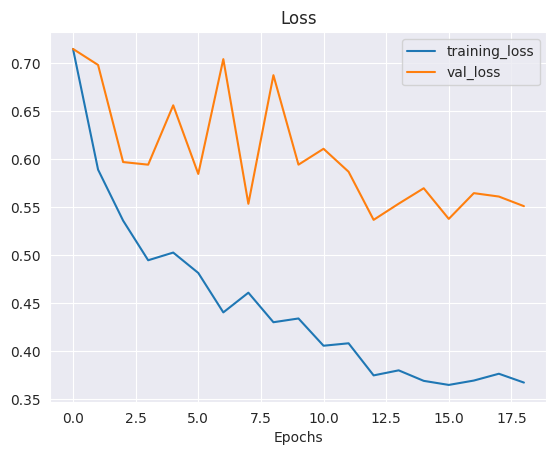

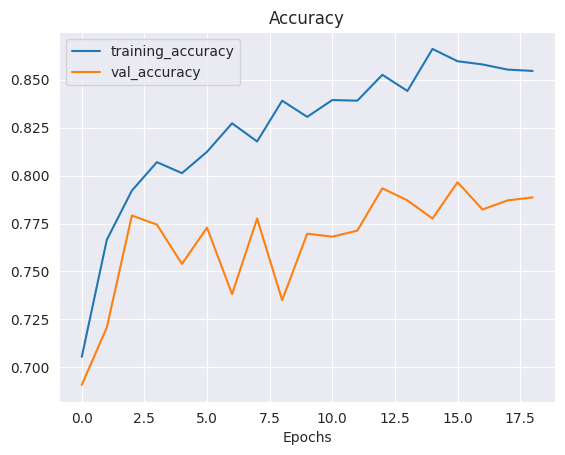

In [ ]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 43ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       158
           1       0.86      0.89      0.88       166
           2       0.89      0.58      0.71       154
           3       0.68      0.86      0.76       162

    accuracy                           0.81       640
   macro avg       0.83      0.81      0.81       640
weighted avg       0.83      0.81      0.81       640

Specificity: [0.285140562248996, 0.3008130081300813, 0.16363636363636364, 0.28]
Mean Squared Error: : 0.1278027445077896
The average AUC-ROC is 0.9544884963371529


[0.9665970772442589,
 0.6623931623931624,
 0.7142857142857143,
 0.663594470046083,
 0.6555323590814196,
 0.9615384615384616,
 0.6957328385899815,
 0.652073732718894,
 0.7098121085594989,
 0.6923076923076923,
 0.8812615955473099,
 0.7350230414746544,
 0.6680584551148225,
 0.6837606837606838,
 0.7087198515769945,
 0.9493087557603687]

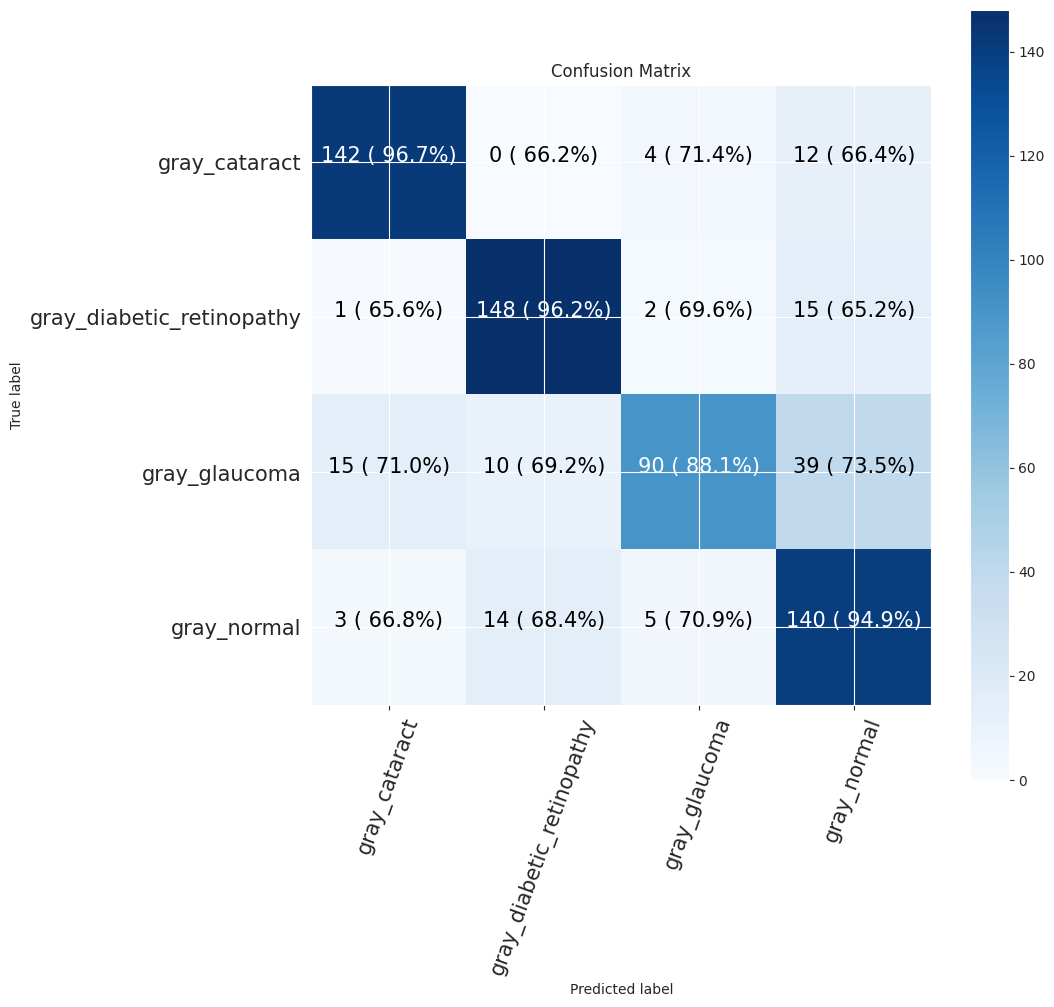

In [ ]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


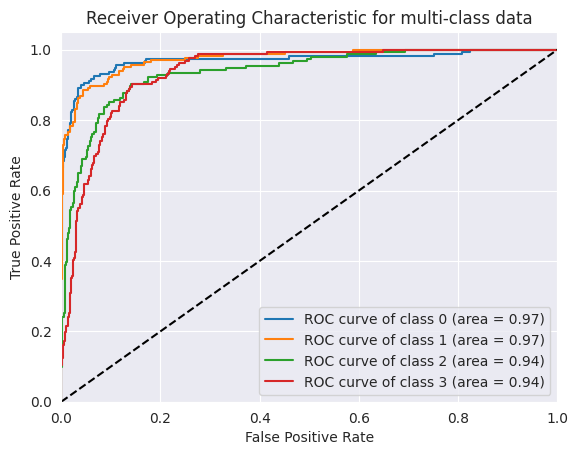

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [ ]:

from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

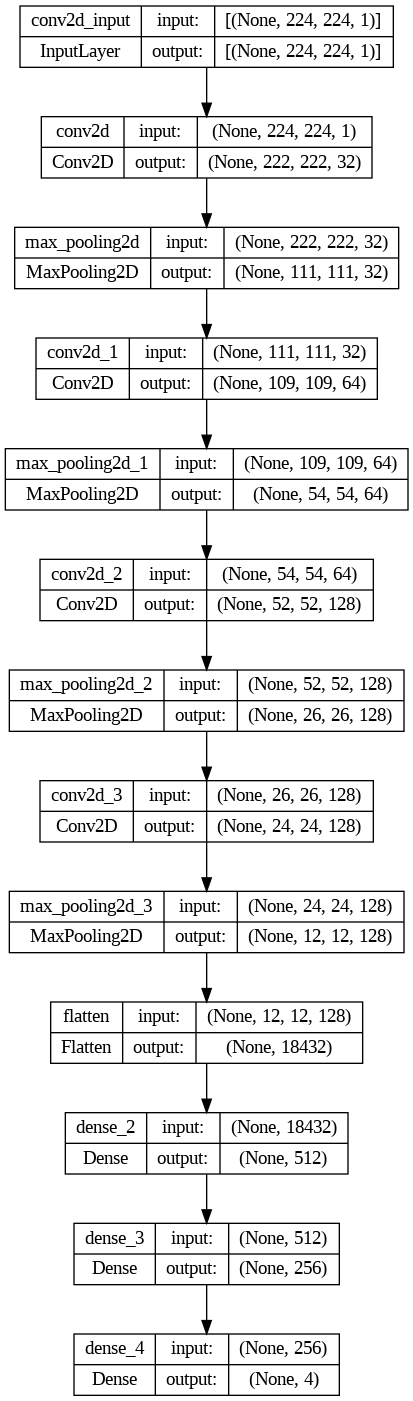

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 9s 24ms/step - loss: 2.2353 - accuracy: 0.5621 - val_loss: 0.8003 - val_accuracy: 0.6577 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 4s 23ms/step - loss: 0.6743 - accuracy: 0.6765 - val_loss: 0.7165 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 4s 22ms/step - loss: 0.6121 - accuracy: 0.7169 - val_loss: 0.6665 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 4s 21ms/step - loss: 0.6065 - accuracy: 0.7213 - val_loss: 0.6792 - val_accuracy: 0.7098 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 4s 21ms/step - loss: 0.5778 - accuracy: 0.7362 - val_loss: 0.6352 - val_accuracy: 0.7161 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 4s 22ms/step - loss: 0.5715 - accuracy: 0.7399 - val_loss: 0.6464 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 7/20
186/186 [==============================] - 4s 21ms/st

CNN Evaluation

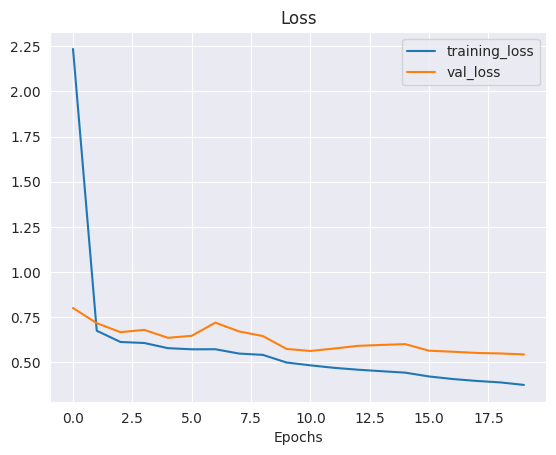

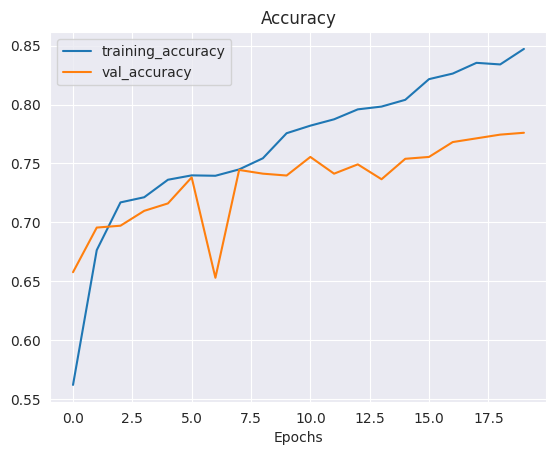

In [ ]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       158
           1       0.99      1.00      0.99       166
           2       0.69      0.62      0.65       154
           3       0.72      0.90      0.80       162

    accuracy                           0.78       640
   macro avg       0.77      0.77      0.77       640
weighted avg       0.77      0.78      0.77       640

Specificity: [0.16363636363636364, 0.350210970464135, 0.17647058823529413, 0.29292929292929293]
Mean Squared Error: : 0.13152678310871124
The average AUC-ROC is 0.9130803837897795


[0.8664047151277013,
 0.6652542372881356,
 0.756,
 0.7129840546697038,
 0.6738703339882122,
 1.0,
 0.668,
 0.621867881548975,
 0.7642436149312377,
 0.673728813559322,
 0.884,
 0.7038724373576309,
 0.6954813359528488,
 0.6610169491525424,
 0.692,
 0.9612756264236902]

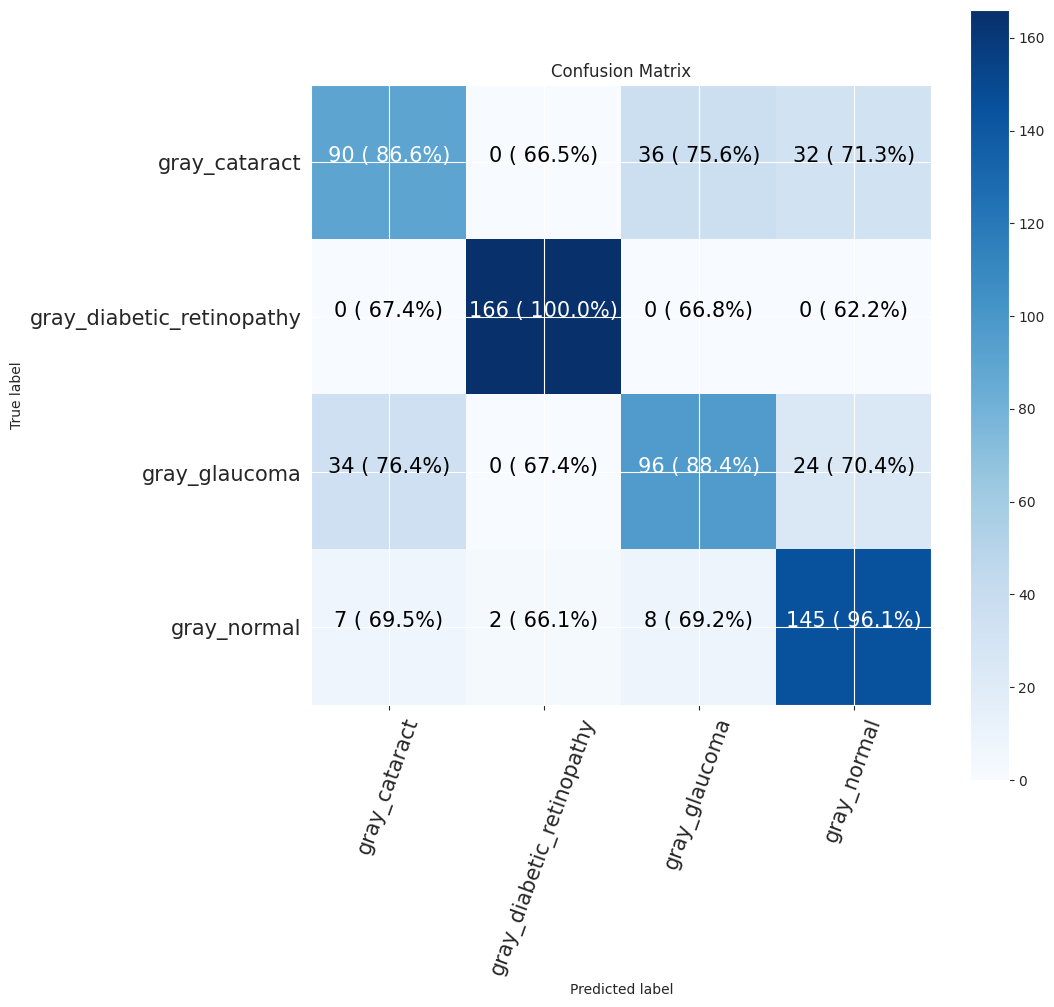

In [ ]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


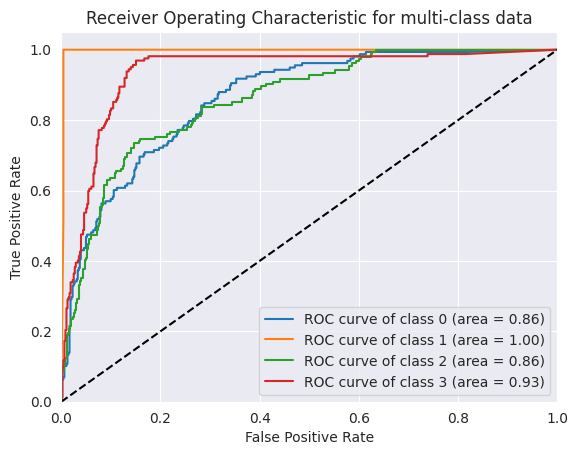

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

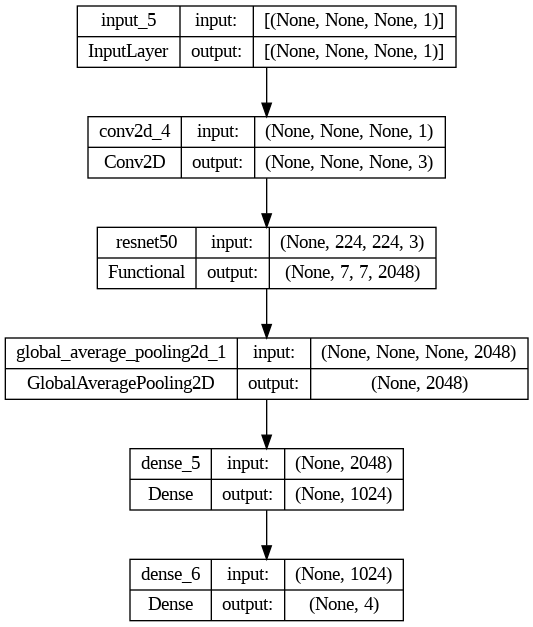

In [ ]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [ ]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 35s 157ms/step - loss: 0.7039 - accuracy: 0.7584 - val_loss: 0.4172 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 27s 144ms/step - loss: 0.3928 - accuracy: 0.8495 - val_loss: 0.3710 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 27s 143ms/step - loss: 0.3244 - accuracy: 0.8715 - val_loss: 0.4840 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 27s 144ms/step - loss: 0.2869 - accuracy: 0.8866 - val_loss: 0.3223 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 27s 144ms/step - loss: 0.2762 - accuracy: 0.8877 - val_loss: 0.3210 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 27s 144ms/step - loss: 0.2512 - accuracy: 0.8998 - val_loss: 0.2985 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

ResNet50 Evaluation

In [ ]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 50ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       158
           1       0.99      0.99      0.99       166
           2       0.80      0.89      0.84       154
           3       0.89      0.82      0.86       162

    accuracy                           0.90       640
   macro avg       0.90      0.89      0.89       640
weighted avg       0.90      0.90      0.90       640

Specificity: [0.2749003984063745, 0.3473684210526316, 0.27236580516898606, 0.26232741617357]
Mean Squared Error: : 0.10876917839050293
The average AUC-ROC is 0.9849425787495636


[0.9588477366255144,
 0.6666666666666666,
 0.6929637526652452,
 0.6904276985743381,
 0.6604938271604939,
 0.9978902953586498,
 0.6460554371002132,
 0.6619144602851323,
 0.6975308641975309,
 0.6751054852320675,
 0.9637526652452025,
 0.7067209775967414,
 0.6831275720164609,
 0.6603375527426161,
 0.697228144989339,
 0.9409368635437881]

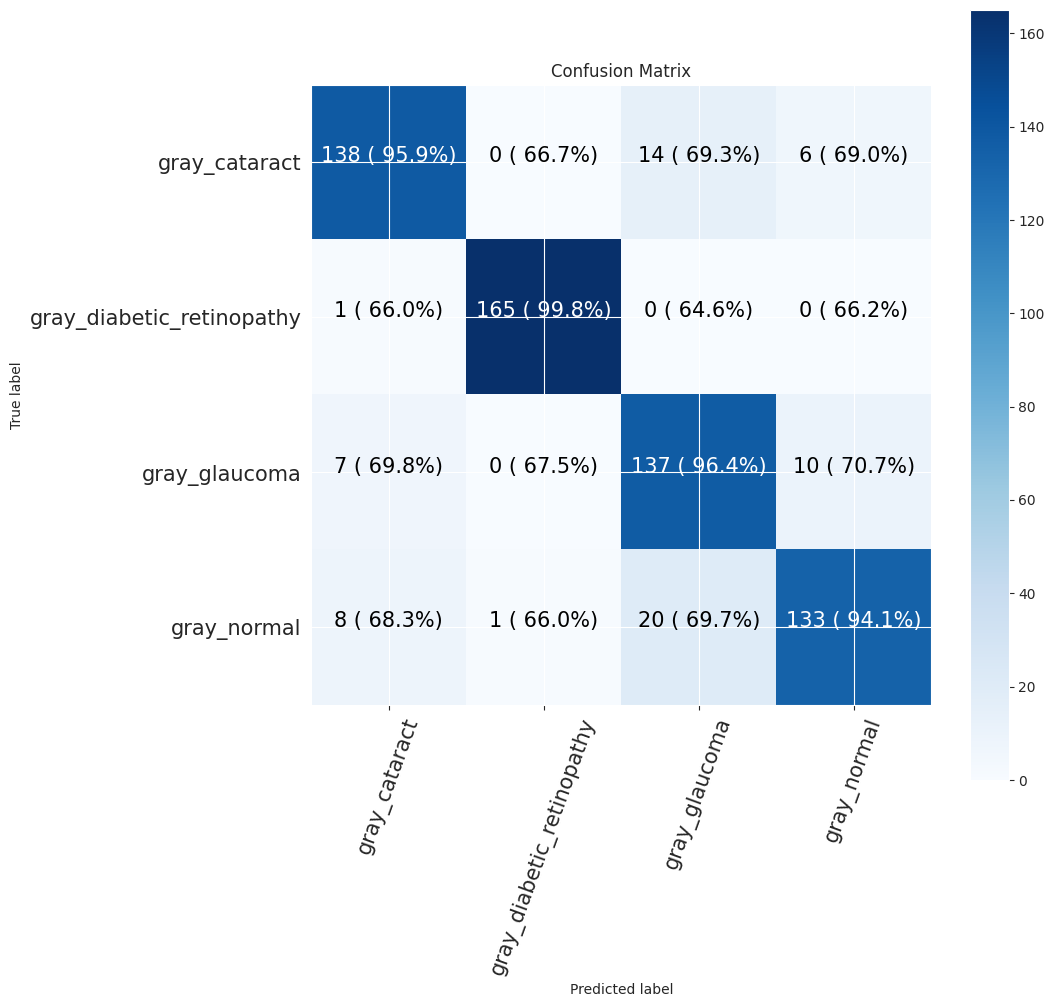

In [ ]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


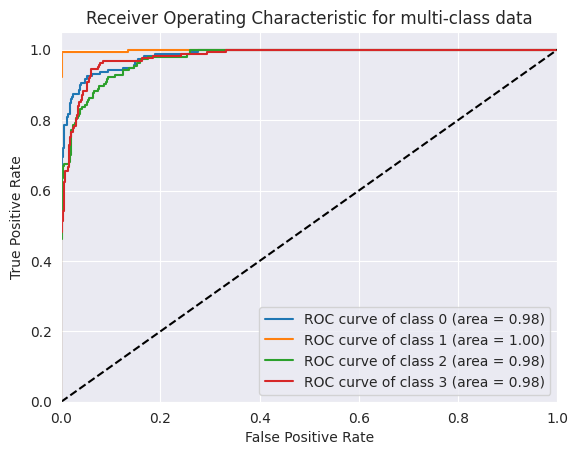

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

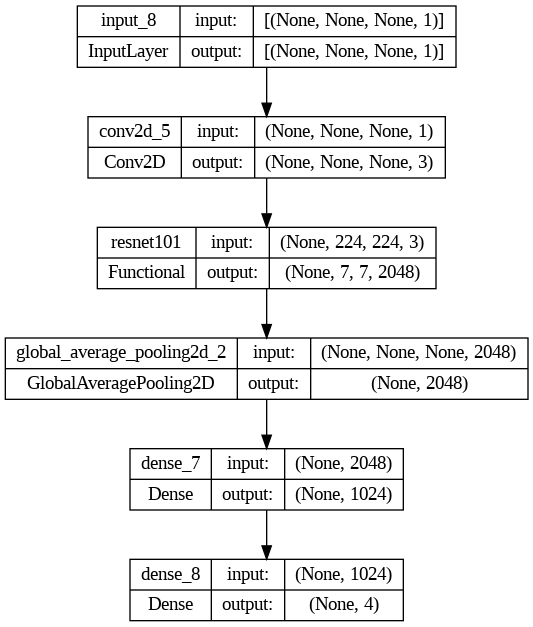

In [ ]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [ ]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 53s 244ms/step - loss: 0.7158 - accuracy: 0.7567 - val_loss: 0.4053 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 44s 237ms/step - loss: 0.3888 - accuracy: 0.8455 - val_loss: 0.3787 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 44s 235ms/step - loss: 0.3382 - accuracy: 0.8677 - val_loss: 0.3452 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 44s 236ms/step - loss: 0.3035 - accuracy: 0.8796 - val_loss: 0.4734 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 44s 236ms/step - loss: 0.2916 - accuracy: 0.8900 - val_loss: 0.3593 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 44s 236ms/step - loss: 0.2496 - accuracy: 0.9022 - val_loss: 0.5159 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

ResNet101 Evaluation

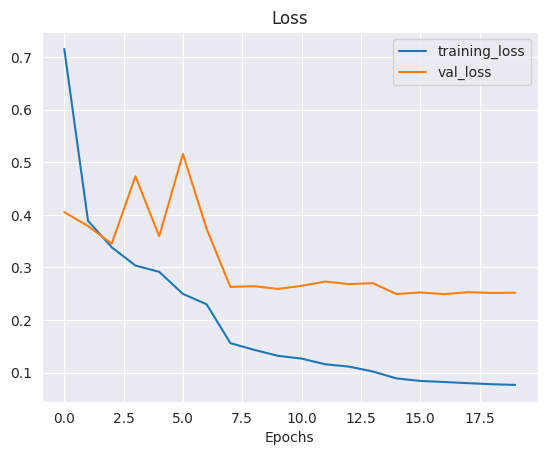

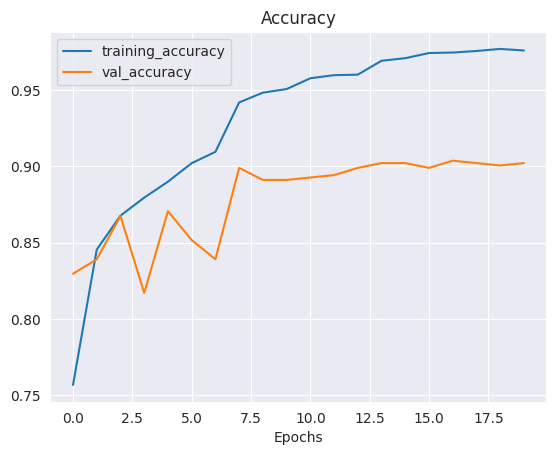

In [ ]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 3s 85ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       158
           1       0.99      0.98      0.98       166
           2       0.77      0.86      0.82       154
           3       0.88      0.83      0.85       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.26732673267326734, 0.3389121338912134, 0.26232741617357, 0.2648221343873518]
Mean Squared Error: : 0.11165189743041992
The average AUC-ROC is 0.9793528725893325


[0.9528688524590164,
 0.6680672268907563,
 0.6987179487179487,
 0.6885245901639344,
 0.6618852459016393,
 0.9915966386554622,
 0.6495726495726496,
 0.6618852459016393,
 0.7028688524590164,
 0.6785714285714286,
 0.9551282051282052,
 0.7069672131147541,
 0.6823770491803278,
 0.6617647058823529,
 0.6965811965811965,
 0.9426229508196722]

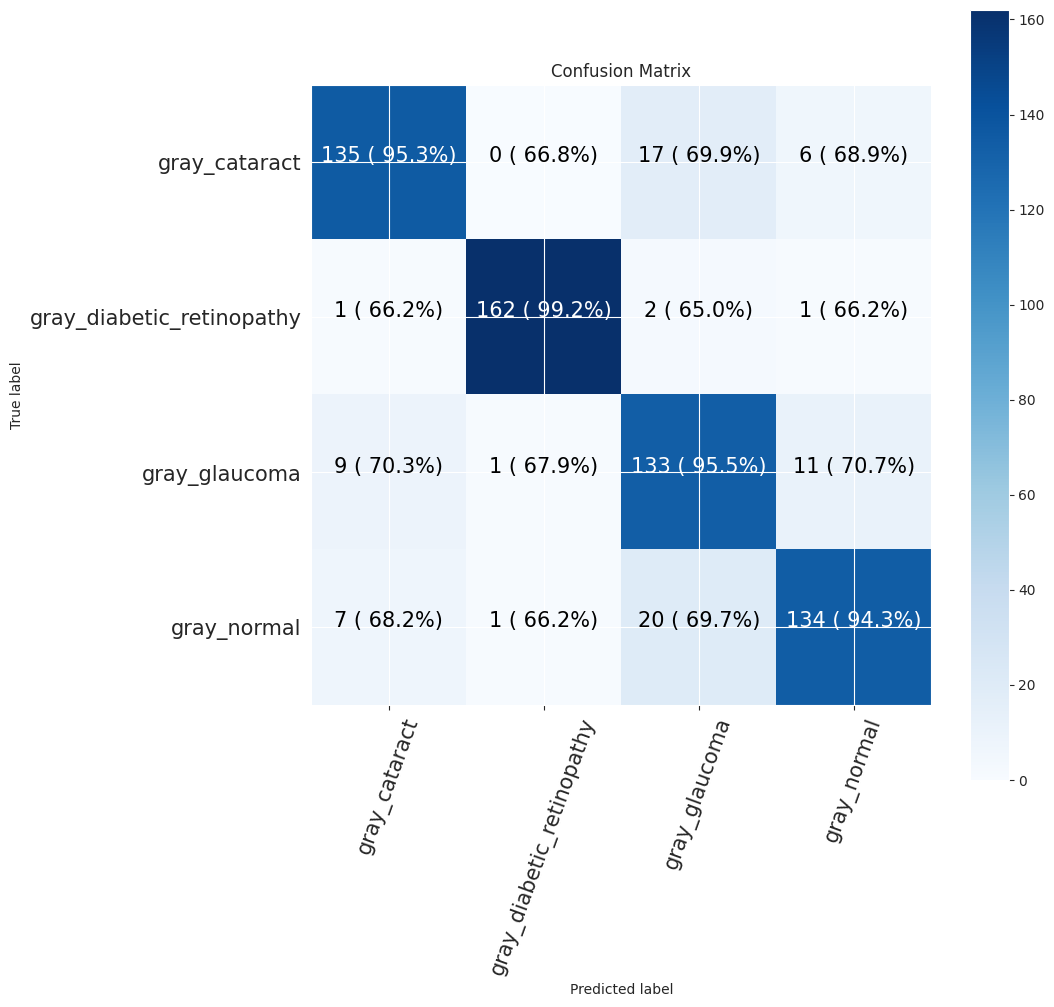

In [ ]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


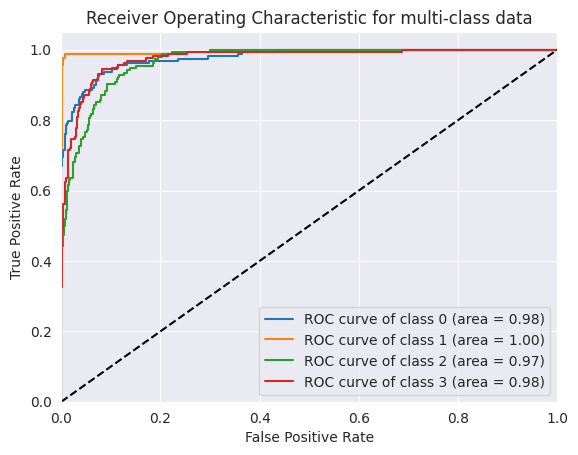

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [8]:
epoch = 20
batchsize = 32

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [ ]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [ ]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

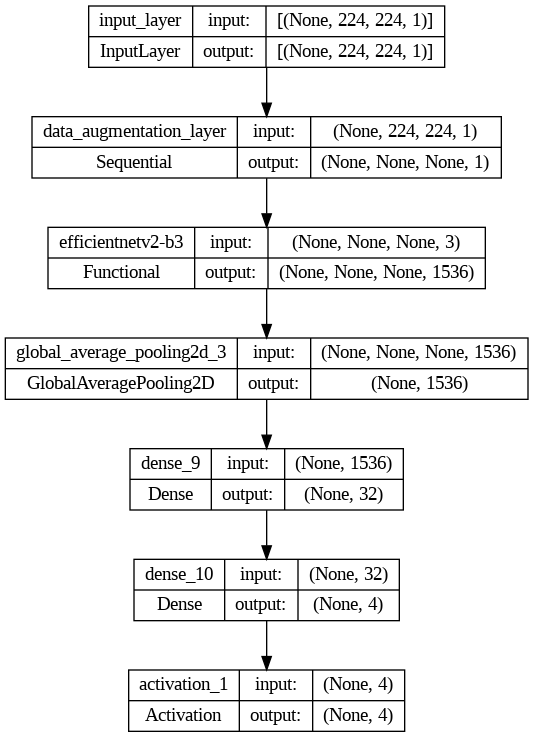

In [ ]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [ ]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 63s 538ms/step - loss: 0.7191 - accuracy: 0.6974 - val_loss: 0.7392 - val_accuracy: 0.7035 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 42s 449ms/step - loss: 0.5639 - accuracy: 0.7740 - val_loss: 0.7954 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 37s 397ms/step - loss: 0.5272 - accuracy: 0.7932 - val_loss: 0.7363 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 36s 381ms/step - loss: 0.4938 - accuracy: 0.8131 - val_loss: 0.7379 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 34s 367ms/step - loss: 0.4848 - accuracy: 0.8131 - val_loss: 0.6634 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 30s 323ms/step - loss: 0.4844 - accuracy: 0.8168 - val_loss: 0.6443 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 32s 345ms/st

EfficientNetV2B3 Evaluation

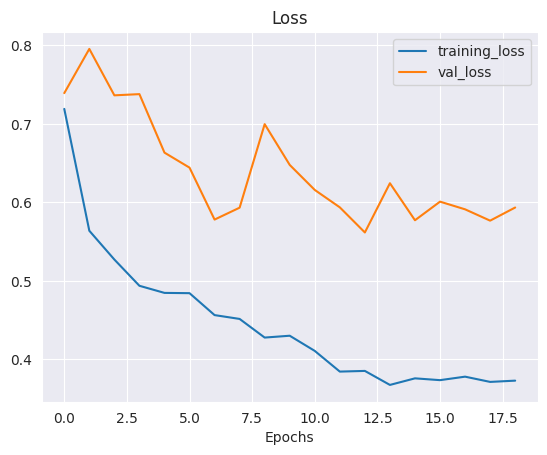

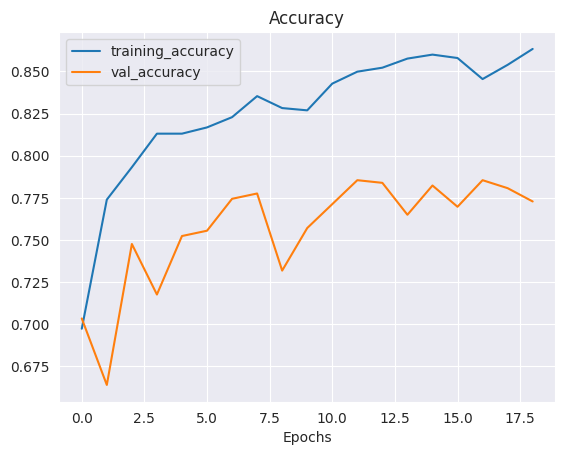

In [ ]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 79ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       158
           1       0.81      0.90      0.85       166
           2       0.88      0.55      0.67       154
           3       0.67      0.83      0.74       162

    accuracy                           0.80       640
   macro avg       0.81      0.79      0.79       640
weighted avg       0.81      0.80      0.79       640

Specificity: [0.28256513026052105, 0.30612244897959184, 0.1510791366906475, 0.2648221343873518]
Mean Squared Error: : 0.129812553524971
The average AUC-ROC is 0.9491940452687225


[0.9647302904564315,
 0.6527472527472528,
 0.7169117647058824,
 0.6697038724373576,
 0.6576763485477178,
 0.9648351648351648,
 0.7003676470588235,
 0.6492027334851936,
 0.7095435684647303,
 0.6923076923076923,
 0.8713235294117647,
 0.744874715261959,
 0.6680497925311203,
 0.6901098901098901,
 0.7113970588235294,
 0.9362186788154897]

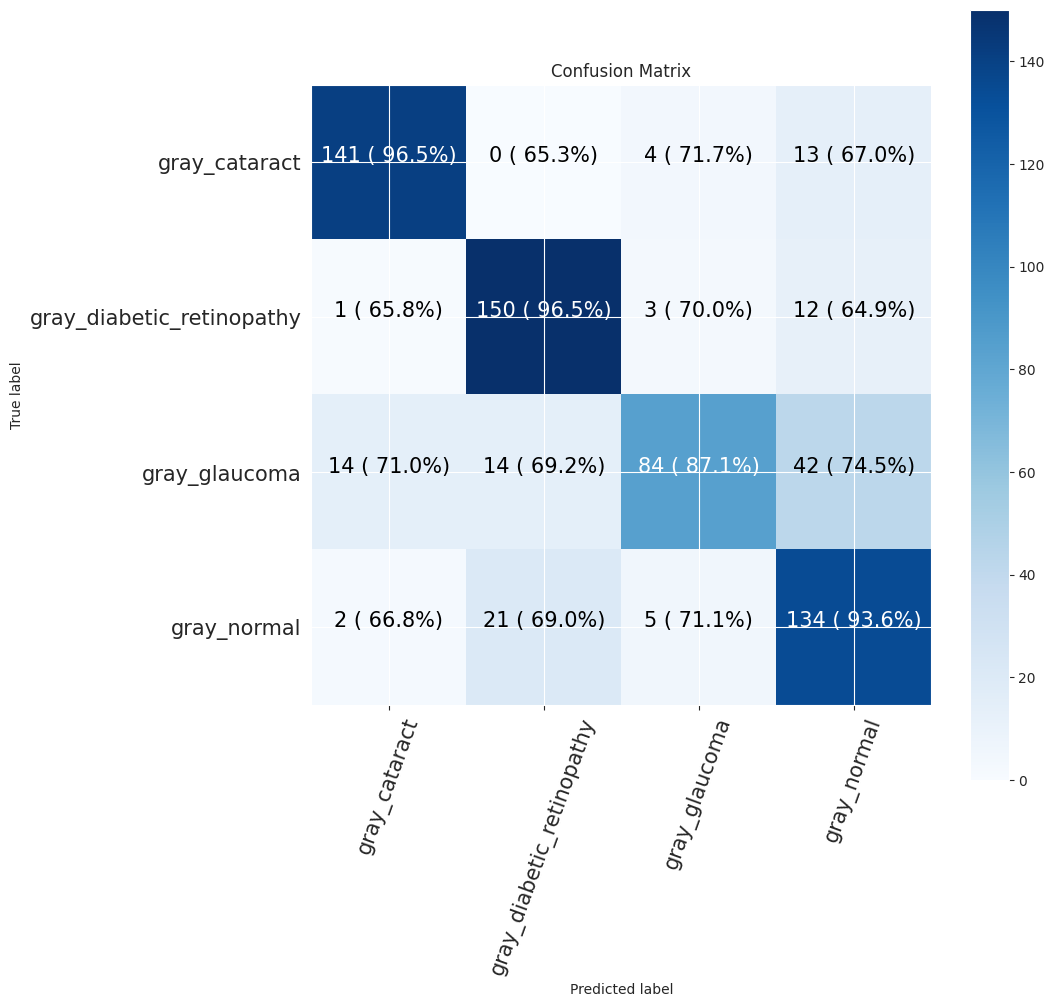

In [ ]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


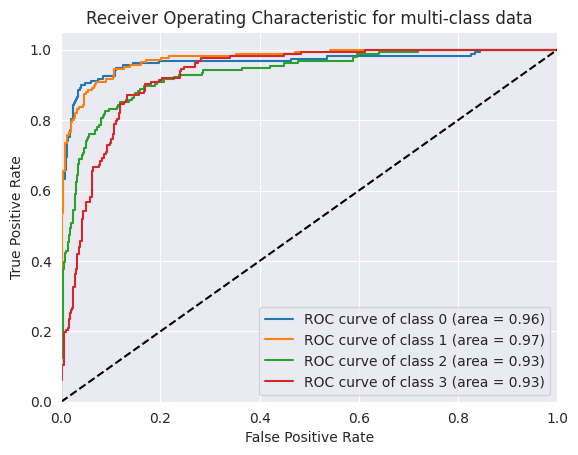

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [ ]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

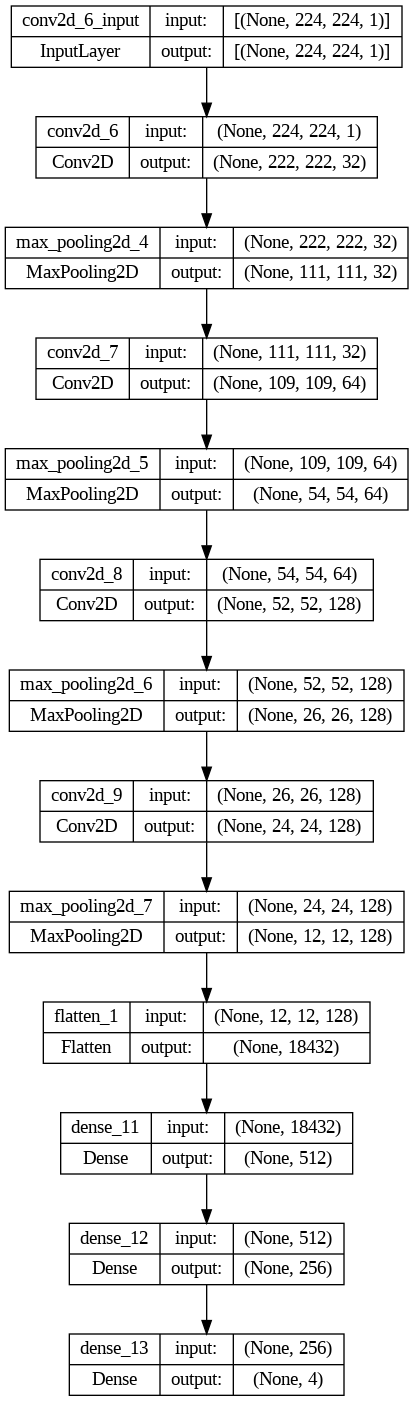

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 7s 47ms/step - loss: 4.3829 - accuracy: 0.5078 - val_loss: 0.9923 - val_accuracy: 0.5615 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 4s 38ms/step - loss: 0.7707 - accuracy: 0.6461 - val_loss: 0.7504 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 4s 38ms/step - loss: 0.6481 - accuracy: 0.6960 - val_loss: 0.6929 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 4s 38ms/step - loss: 0.6073 - accuracy: 0.7254 - val_loss: 0.6408 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 4s 38ms/step - loss: 0.5798 - accuracy: 0.7328 - val_loss: 0.6593 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 4s 38ms/step - loss: 0.5880 - accuracy: 0.7314 - val_loss: 0.6691 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 4s 38ms/step - loss: 0.5

CNN Evaluation

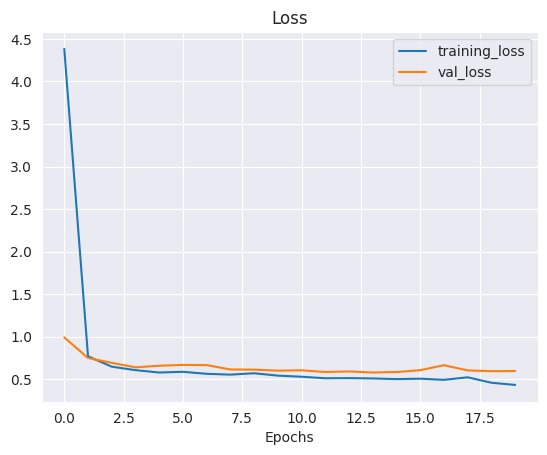

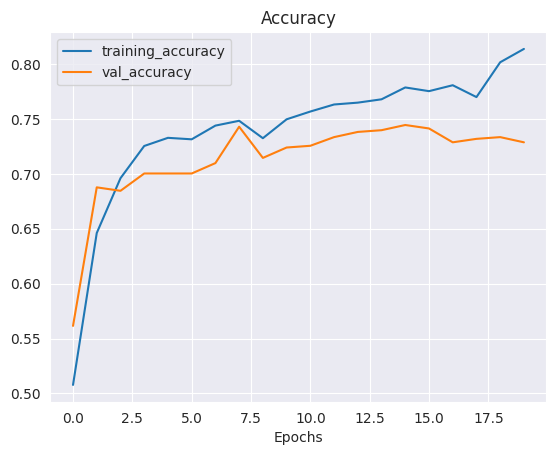

In [ ]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.49      0.55       158
           1       0.99      1.00      0.99       166
           2       0.60      0.55      0.57       154
           3       0.70      0.88      0.78       162

    accuracy                           0.74       640
   macro avg       0.73      0.73      0.72       640
weighted avg       0.73      0.74      0.73       640

Specificity: [0.1387900355871886, 0.350210970464135, 0.15315315315315314, 0.28772635814889336]
Mean Squared Error: : 0.13631334900856018
The average AUC-ROC is 0.8961691784397682


[0.8443579766536965,
 0.6652542372881356,
 0.7771084337349398,
 0.713302752293578,
 0.6770428015564203,
 1.0,
 0.6666666666666666,
 0.6192660550458715,
 0.7782101167315175,
 0.6758474576271186,
 0.8614457831325302,
 0.7110091743119266,
 0.7003891050583657,
 0.6588983050847458,
 0.6947791164658634,
 0.9564220183486238]

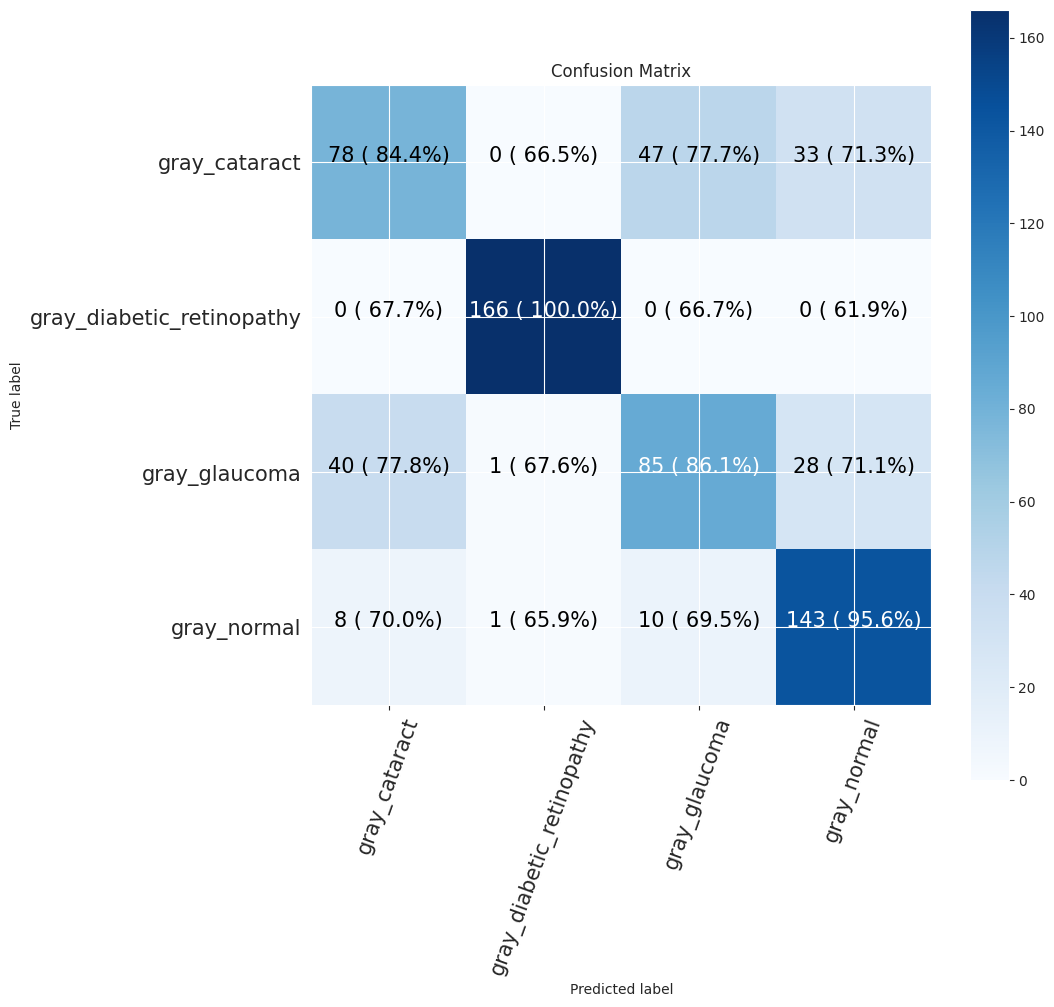

In [ ]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


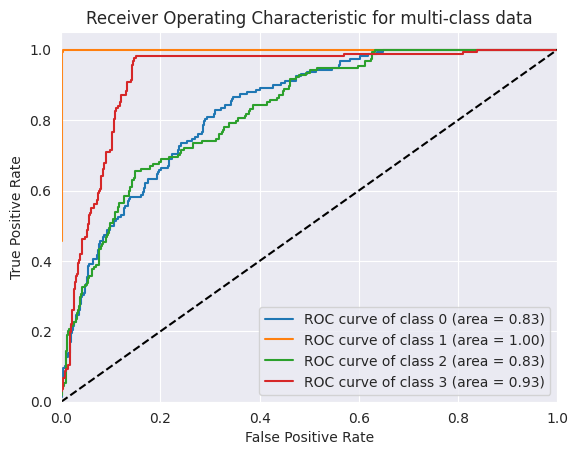

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

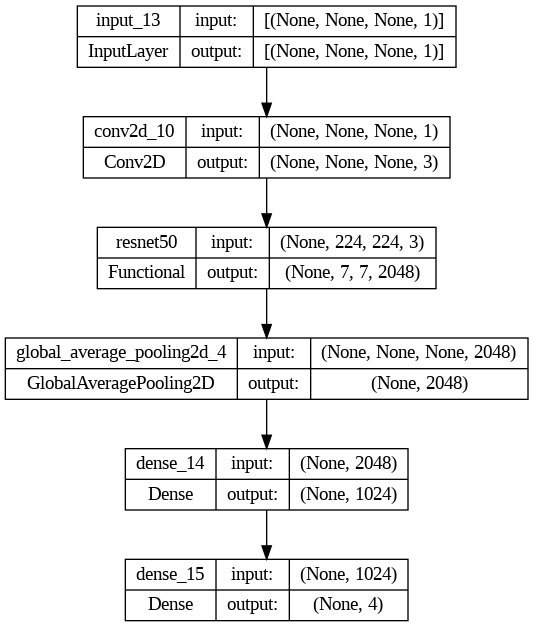

In [ ]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [ ]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 35s 313ms/step - loss: 0.7154 - accuracy: 0.7443 - val_loss: 0.4423 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 26s 276ms/step - loss: 0.3692 - accuracy: 0.8576 - val_loss: 0.3585 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 25s 271ms/step - loss: 0.3033 - accuracy: 0.8752 - val_loss: 0.3402 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 25s 272ms/step - loss: 0.2731 - accuracy: 0.8944 - val_loss: 0.4461 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 26s 274ms/step - loss: 0.2418 - accuracy: 0.9065 - val_loss: 0.2939 - val_accuracy: 0.8896 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 25s 273ms/step - loss: 0.2097 - accuracy: 0.9197 - val_loss: 0.3123 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 26s 274ms/st

ResNet50 Evaluation

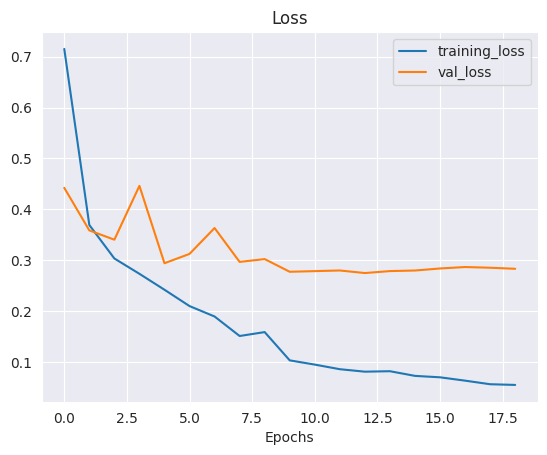

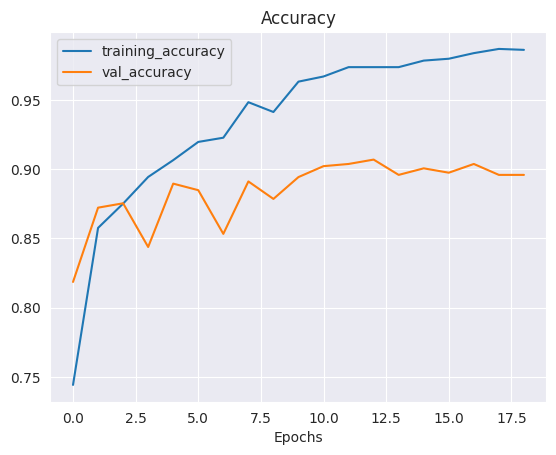

In [ ]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 94ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       158
           1       0.98      0.98      0.98       166
           2       0.82      0.88      0.85       154
           3       0.88      0.83      0.85       162

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640

Specificity: [0.285140562248996, 0.3417190775681342, 0.2698412698412698, 0.2648221343873518]
Mean Squared Error: : 0.10928916931152344
The average AUC-ROC is 0.9827466996255556


[0.9670103092783505,
 0.6659619450317125,
 0.6821052631578948,
 0.6940451745379876,
 0.6597938144329897,
 0.9936575052854123,
 0.6526315789473685,
 0.6611909650924025,
 0.6969072164948453,
 0.678646934460888,
 0.9621052631578947,
 0.702258726899384,
 0.6762886597938145,
 0.6617336152219874,
 0.7031578947368421,
 0.9425051334702259]

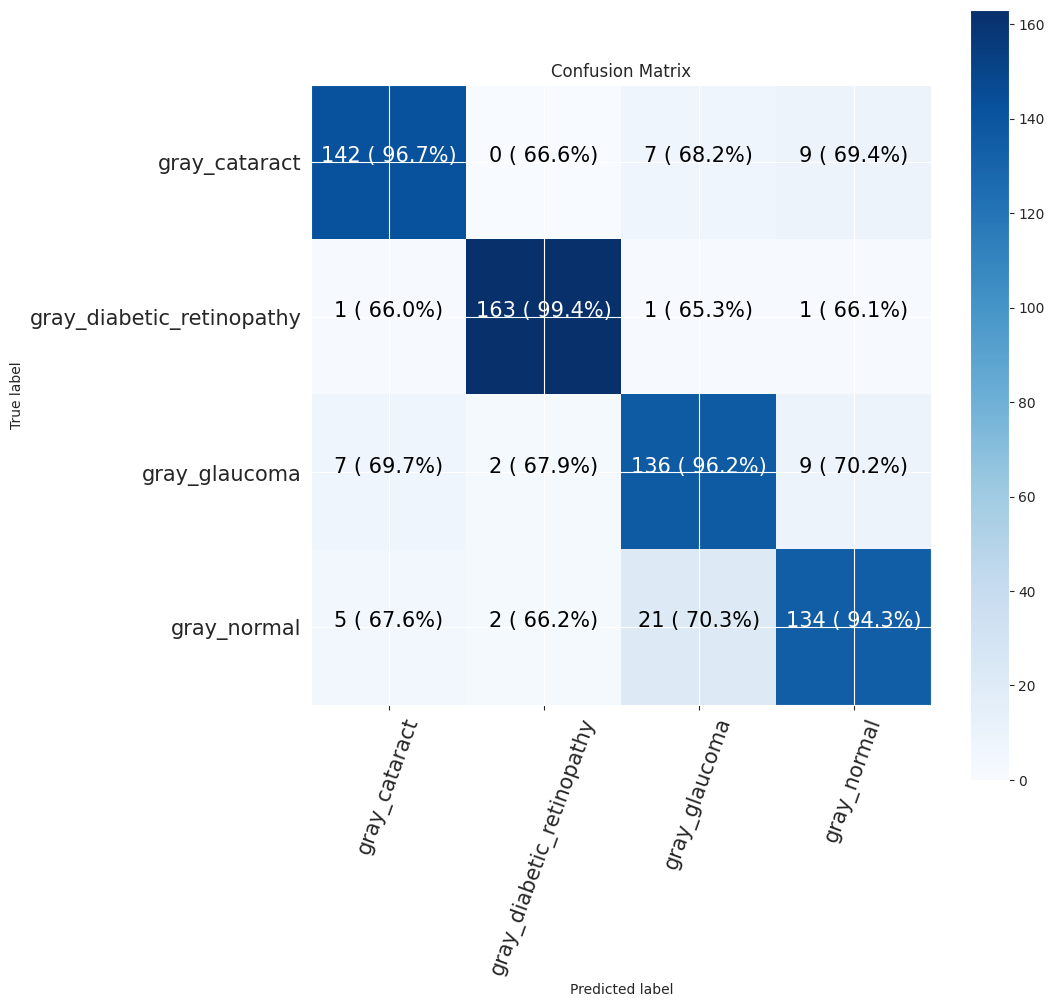

In [ ]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


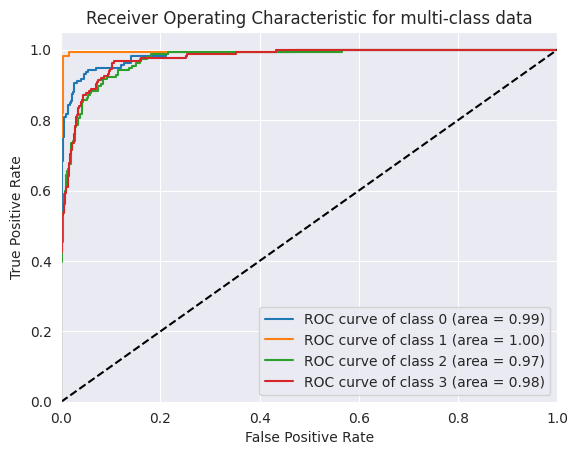

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [10]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 4)                 4100 

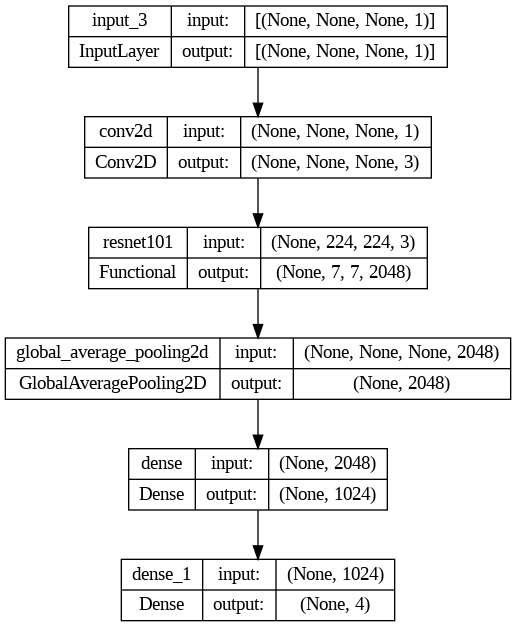

In [11]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [12]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [13]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 61s 483ms/step - loss: 0.8092 - accuracy: 0.7500 - val_loss: 0.4541 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 42s 450ms/step - loss: 0.3849 - accuracy: 0.8529 - val_loss: 0.4491 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 41s 444ms/step - loss: 0.3255 - accuracy: 0.8742 - val_loss: 0.3464 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 42s 447ms/step - loss: 0.2806 - accuracy: 0.8944 - val_loss: 0.3635 - val_accuracy: 0.8628 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 41s 445ms/step - loss: 0.2357 - accuracy: 0.9099 - val_loss: 0.3514 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 42s 447ms/step - loss: 0.2255 - accuracy: 0.9103 - val_loss: 0.3193 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 42s 447ms/st

ResNet101 Evaluation

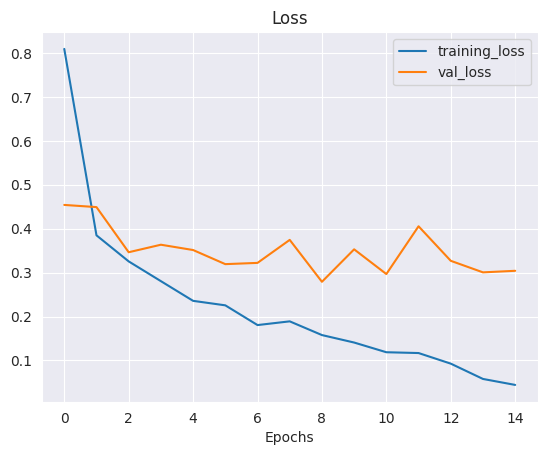

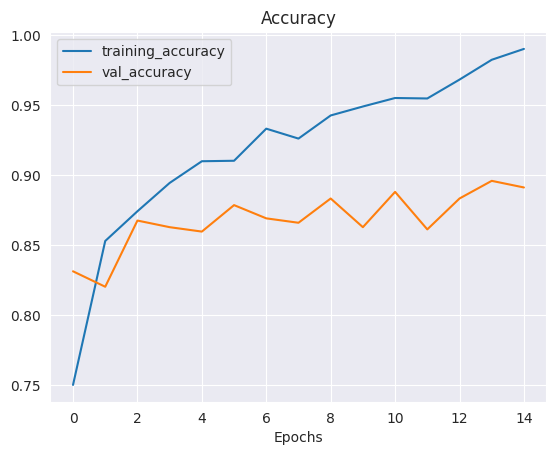

In [14]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 3s 161ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       158
           1       0.97      0.98      0.97       166
           2       0.88      0.80      0.84       154
           3       0.86      0.89      0.87       162

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640

Specificity: [0.29817444219066935, 0.3389121338912134, 0.2379110251450677, 0.2903225806451613]
Mean Squared Error: : 0.10825196653604507
The average AUC-ROC is 0.9826121421562172


[0.9768421052631578,
 0.6701902748414377,
 0.69,
 0.6779661016949152,
 0.6526315789473685,
 0.9915433403805497,
 0.674,
 0.6483050847457628,
 0.7010526315789474,
 0.6765327695560254,
 0.938,
 0.711864406779661,
 0.6694736842105263,
 0.6617336152219874,
 0.698,
 0.961864406779661]

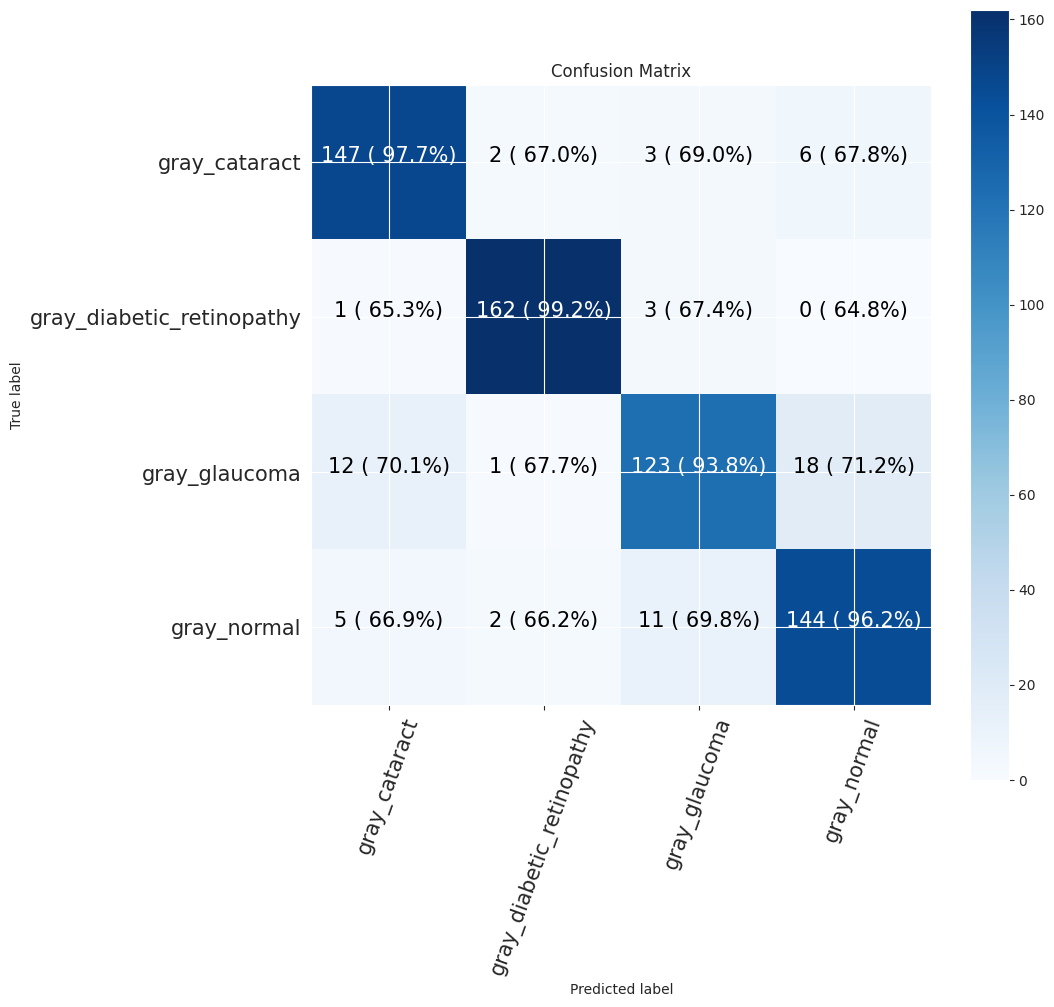

In [15]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


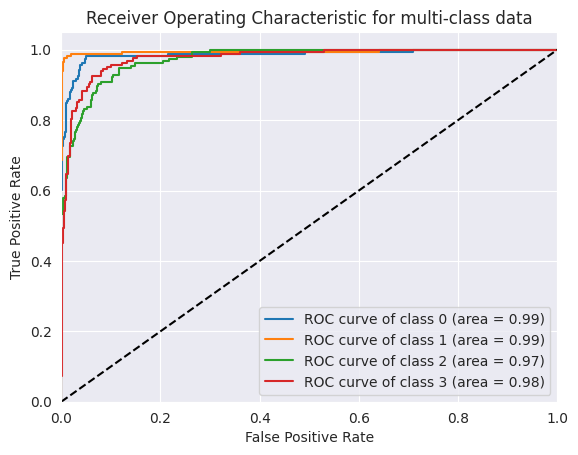

In [16]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [17]:
epoch = 20
batchsize = 64

In [18]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [19]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 2s 0us/step


In [20]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 32)                49184     
                                                           

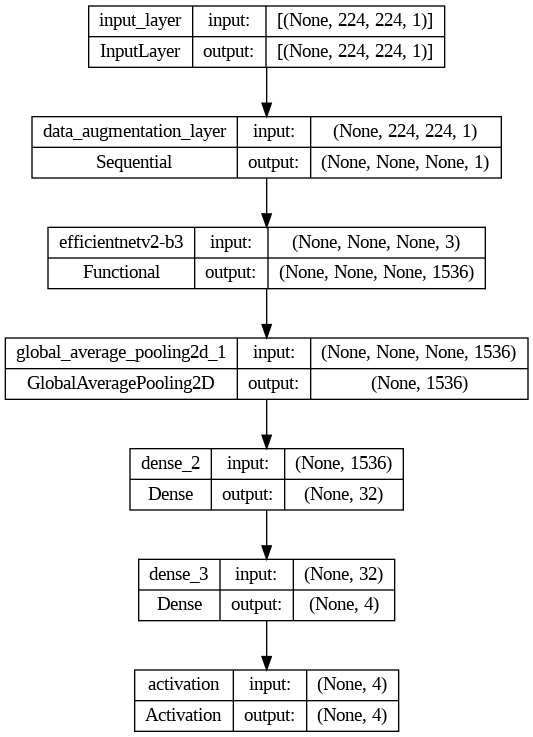

In [21]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [22]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [23]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 60s 1s/step - loss: 0.8023 - accuracy: 0.6636 - val_loss: 0.7197 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 38s 813ms/step - loss: 0.6229 - accuracy: 0.7524 - val_loss: 0.7795 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 40s 842ms/step - loss: 0.5377 - accuracy: 0.7858 - val_loss: 0.6109 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 37s 768ms/step - loss: 0.5167 - accuracy: 0.8043 - val_loss: 0.6329 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 35s 730ms/step - loss: 0.5021 - accuracy: 0.7962 - val_loss: 0.6358 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 34s 726ms/step - loss: 0.5013 - accuracy: 0.8036 - val_loss: 0.6091 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 31s 659ms/step 

EfficientNetV2B3 Evaluation

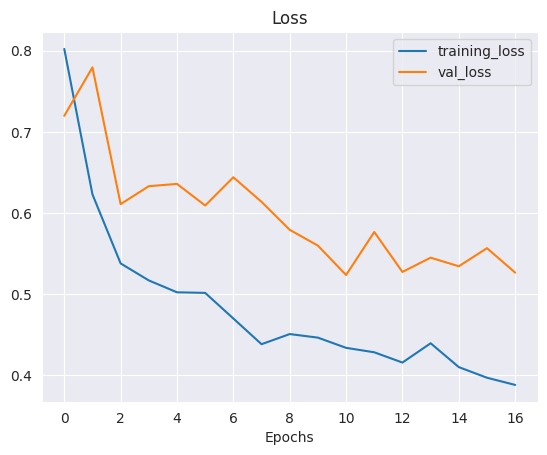

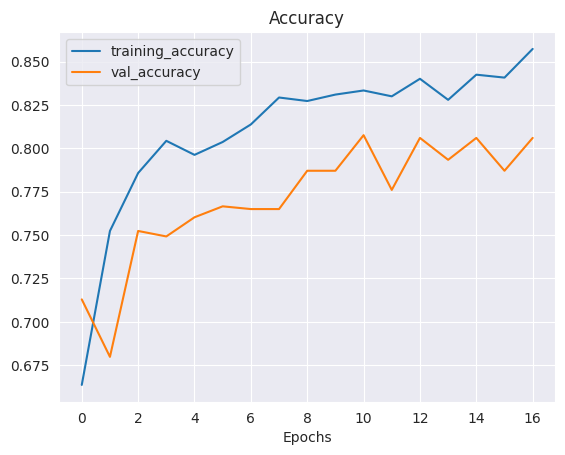

In [24]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       158
           1       0.89      0.83      0.86       166
           2       0.87      0.62      0.73       154
           3       0.68      0.88      0.77       162

    accuracy                           0.81       640
   macro avg       0.82      0.81      0.81       640
weighted avg       0.82      0.81      0.81       640

Specificity: [0.28772635814889336, 0.27236580516898606, 0.17647058823529413, 0.285140562248996]
Mean Squared Error: : 0.12814103066921234
The average AUC-ROC is 0.951554841245707


[0.9682875264270613,
 0.6748971193415638,
 0.7094339622641509,
 0.6589327146171694,
 0.6511627906976745,
 0.9403292181069959,
 0.6962264150943396,
 0.6682134570765661,
 0.7124735729386892,
 0.6975308641975309,
 0.8905660377358491,
 0.7192575406032483,
 0.6680761099365751,
 0.6872427983539094,
 0.7037735849056603,
 0.9535962877030162]

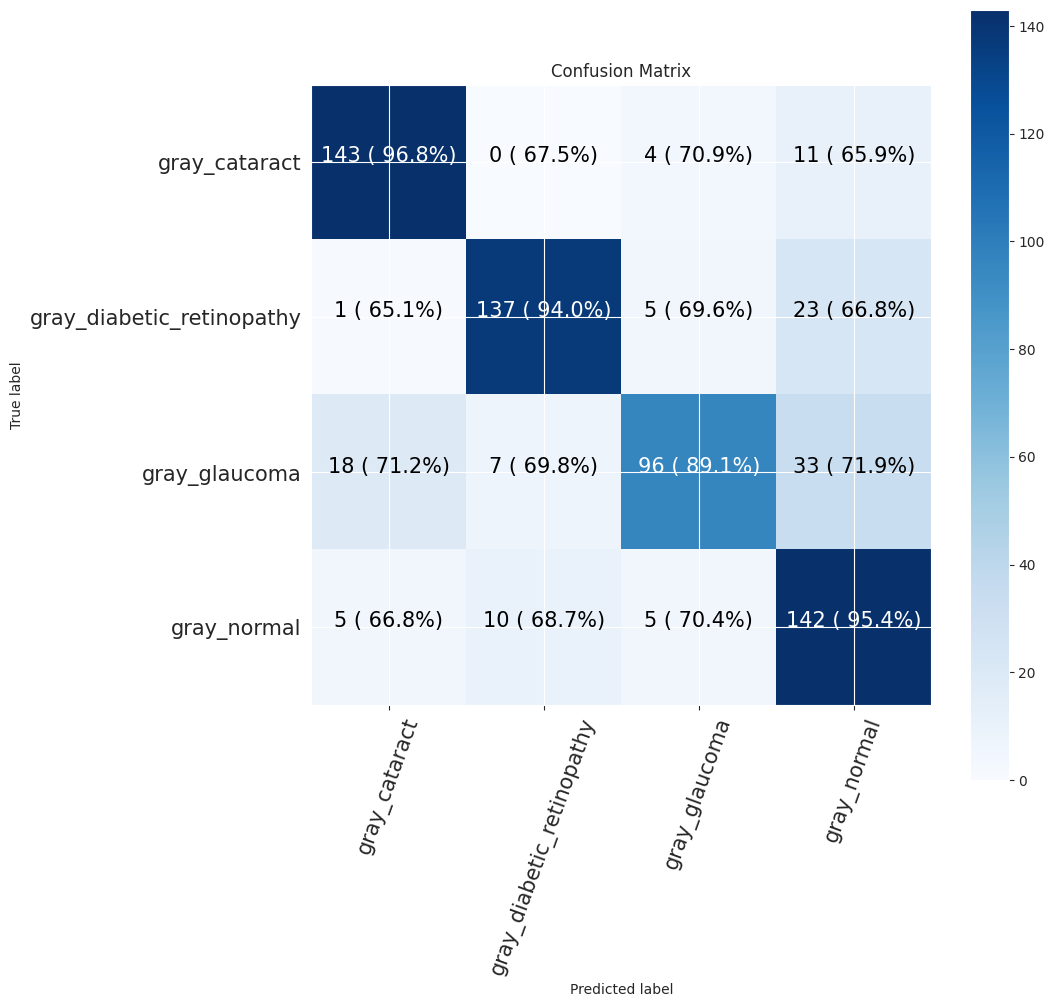

In [25]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


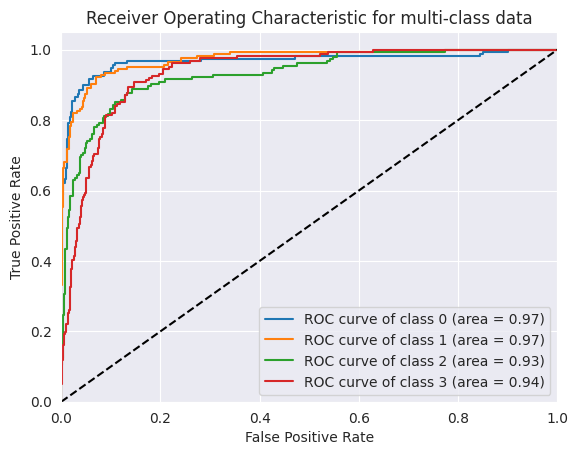

In [26]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [27]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

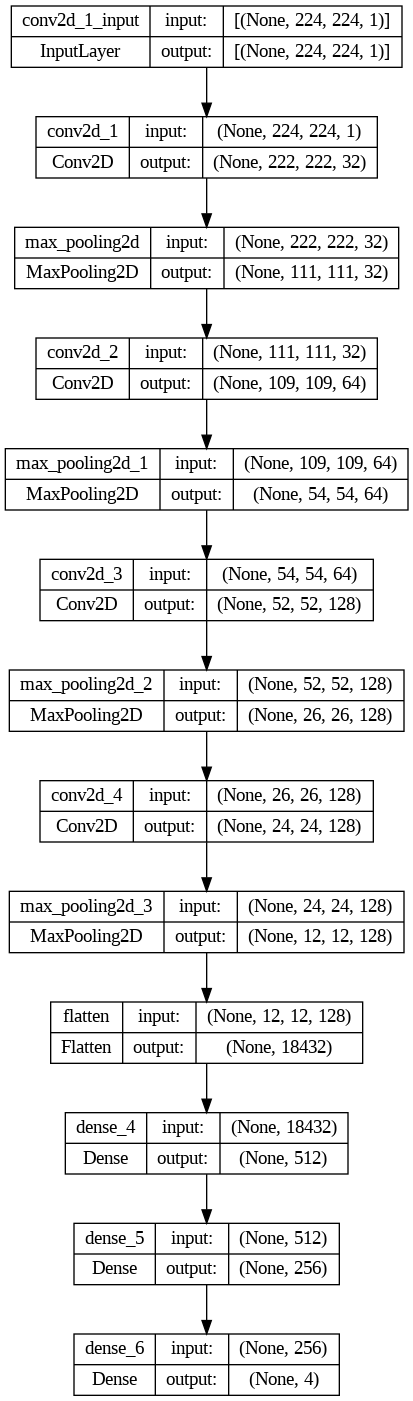

In [28]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [29]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [30]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 7s 89ms/step - loss: 8.6052 - accuracy: 0.4727 - val_loss: 1.0703 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 3s 66ms/step - loss: 0.8190 - accuracy: 0.6579 - val_loss: 0.9191 - val_accuracy: 0.5647 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 3s 67ms/step - loss: 0.6758 - accuracy: 0.7200 - val_loss: 0.8205 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 3s 67ms/step - loss: 0.5999 - accuracy: 0.7517 - val_loss: 0.5684 - val_accuracy: 0.7145 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 3s 67ms/step - loss: 0.4707 - accuracy: 0.7993 - val_loss: 0.5432 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 3s 67ms/step - loss: 0.4621 - accuracy: 0.8023 - val_loss: 0.5761 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 3s 67ms/step - loss: 0.4

CNN Evaluation

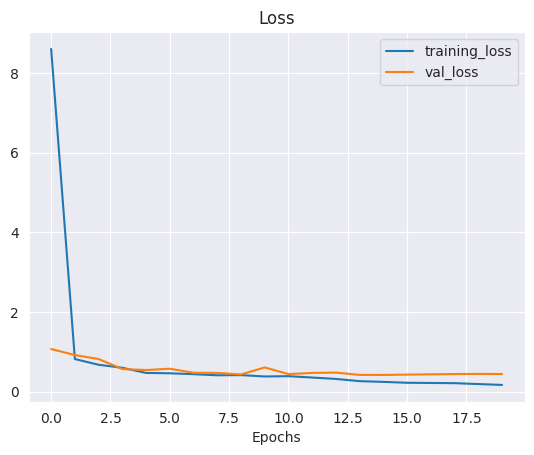

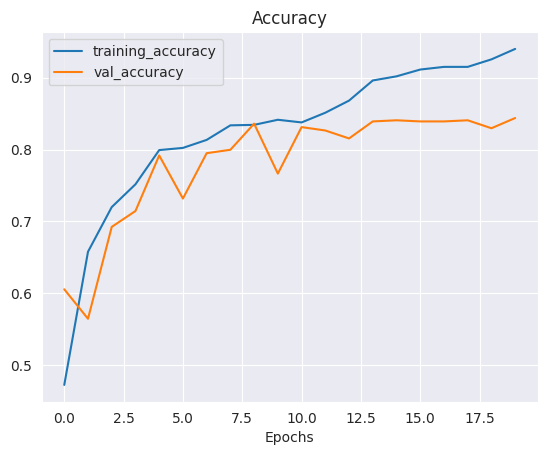

In [31]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       158
           1       0.98      0.99      0.99       166
           2       0.72      0.69      0.71       154
           3       0.76      0.80      0.78       162

    accuracy                           0.82       640
   macro avg       0.82      0.82      0.82       640
weighted avg       0.82      0.82      0.82       640

Specificity: [0.24031007751937986, 0.3473684210526316, 0.20075046904315197, 0.2549019607843137]
Mean Squared Error: : 0.121088907122612
The average AUC-ROC is 0.951889758158363


[0.9300411522633745,
 0.6652542372881356,
 0.717479674796748,
 0.6957446808510638,
 0.6584362139917695,
 0.9978813559322034,
 0.6626016260162602,
 0.648936170212766,
 0.7263374485596708,
 0.6779661016949152,
 0.9044715447154471,
 0.723404255319149,
 0.6851851851851852,
 0.6588983050847458,
 0.7154471544715447,
 0.9319148936170213]

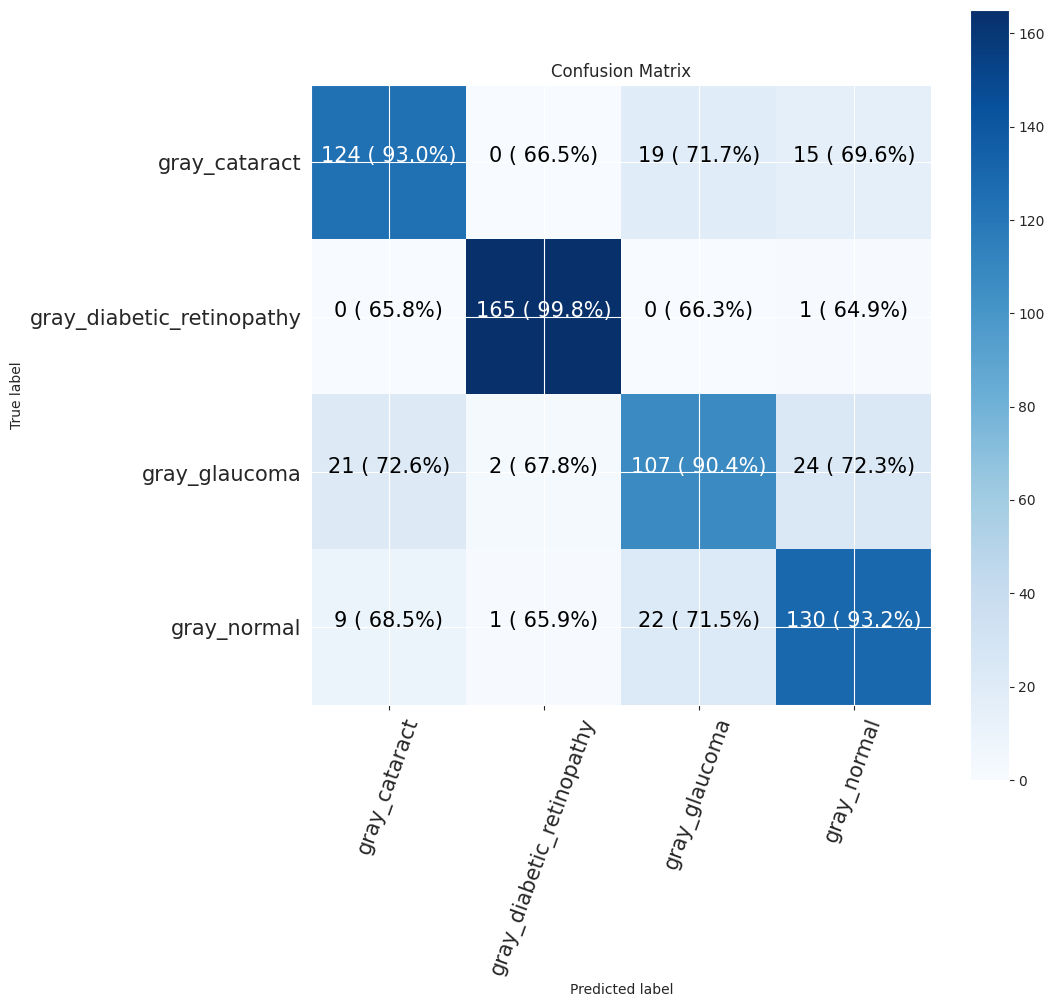

In [32]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


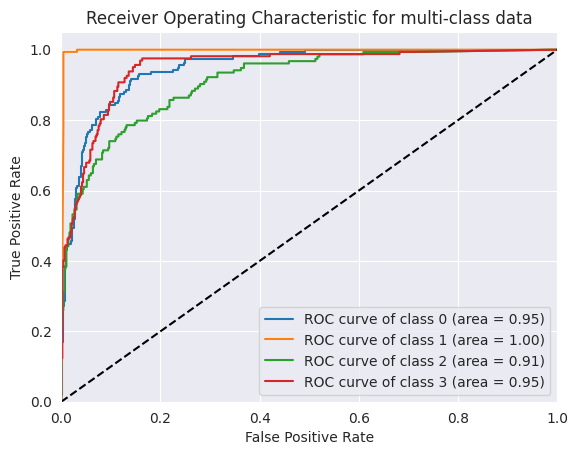

In [33]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [34]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 4100 

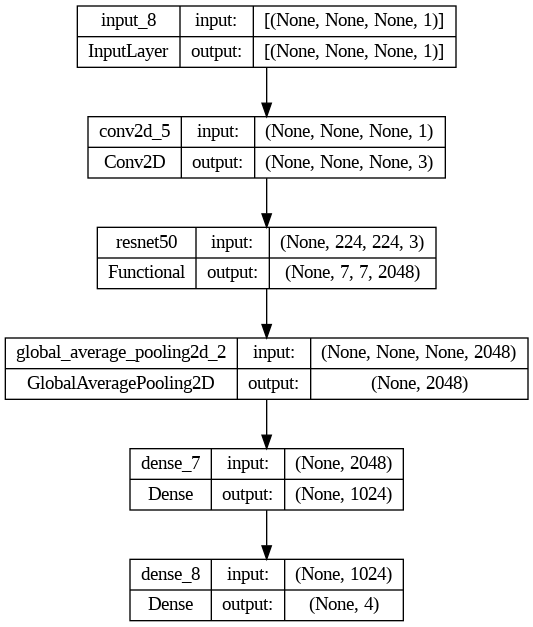

In [35]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [36]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [37]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 34s 576ms/step - loss: 1.0350 - accuracy: 0.6960 - val_loss: 0.5018 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 25s 519ms/step - loss: 0.4258 - accuracy: 0.8354 - val_loss: 0.3892 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 24s 511ms/step - loss: 0.3284 - accuracy: 0.8792 - val_loss: 0.3453 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 24s 513ms/step - loss: 0.2902 - accuracy: 0.8917 - val_loss: 0.3227 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 24s 516ms/step - loss: 0.2687 - accuracy: 0.8964 - val_loss: 0.3793 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 24s 515ms/step - loss: 0.2546 - accuracy: 0.9025 - val_loss: 0.3520 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 24s 514ms/st

ResNet50 Evaluation

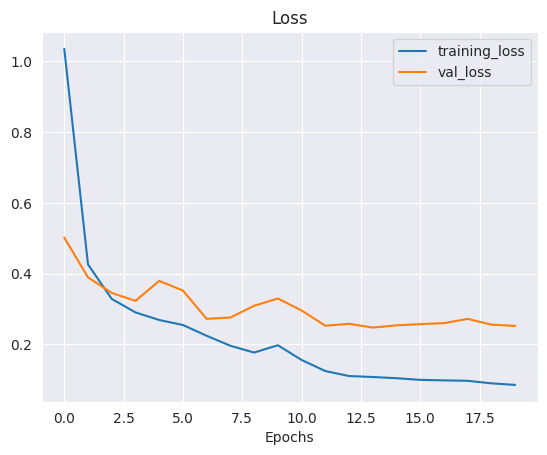

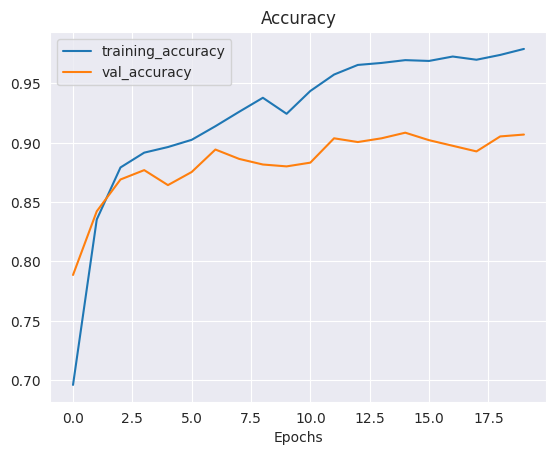

In [38]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 180ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       158
           1       0.98      0.99      0.98       166
           2       0.85      0.84      0.84       154
           3       0.88      0.86      0.87       162

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640

Specificity: [0.28256513026052105, 0.3445378151260504, 0.25244618395303325, 0.28]
Mean Squared Error: : 0.10986896604299545
The average AUC-ROC is 0.9846287748980294


[0.9644351464435147,
 0.6680761099365751,
 0.6967213114754098,
 0.683991683991684,
 0.6548117154811716,
 0.9957716701902748,
 0.6598360655737705,
 0.656964656964657,
 0.7050209205020921,
 0.6744186046511628,
 0.9487704918032787,
 0.7047817047817048,
 0.6757322175732218,
 0.6617336152219874,
 0.694672131147541,
 0.9542619542619543]

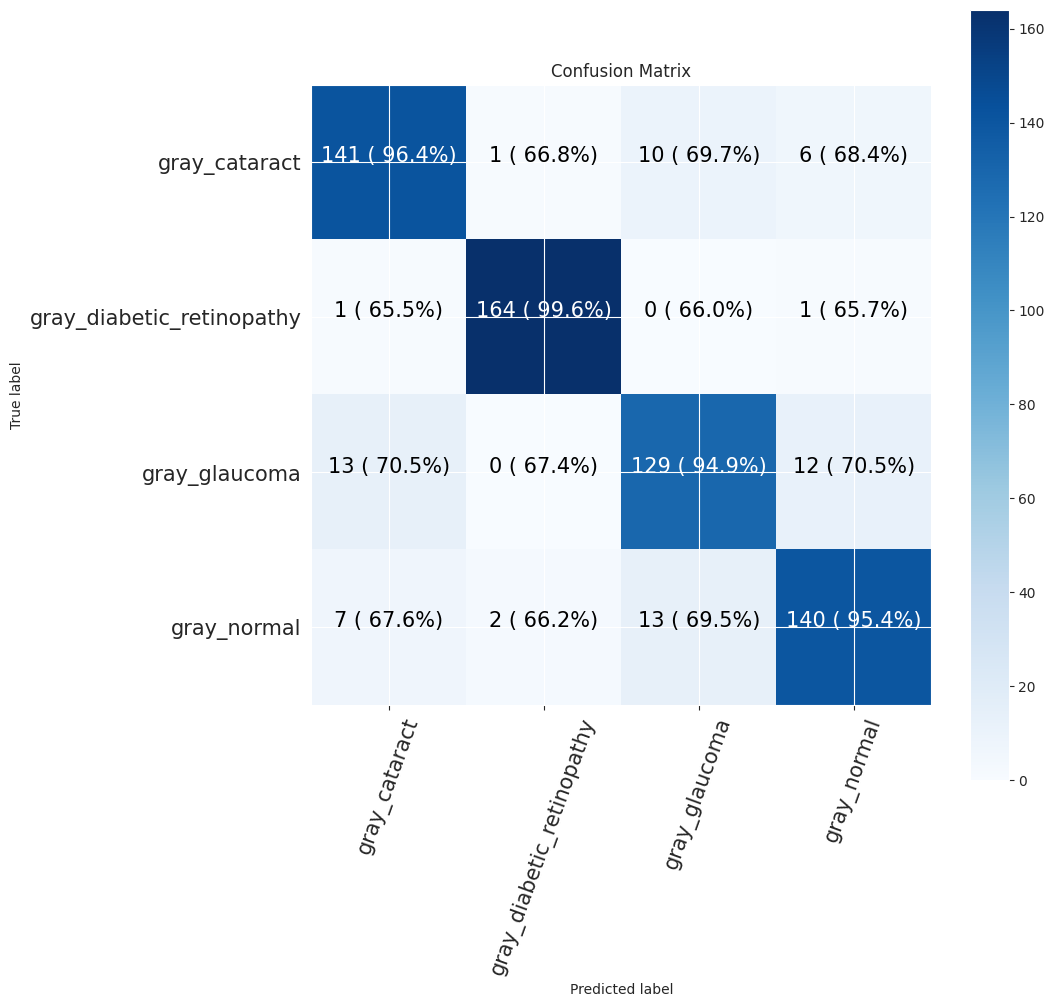

In [39]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


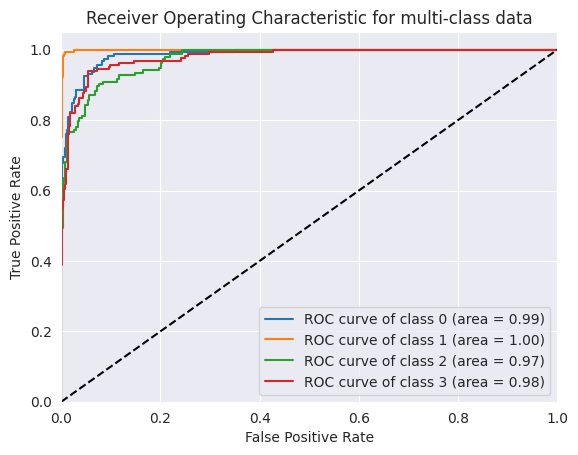

In [40]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [41]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 4)                 4100      
                                                           

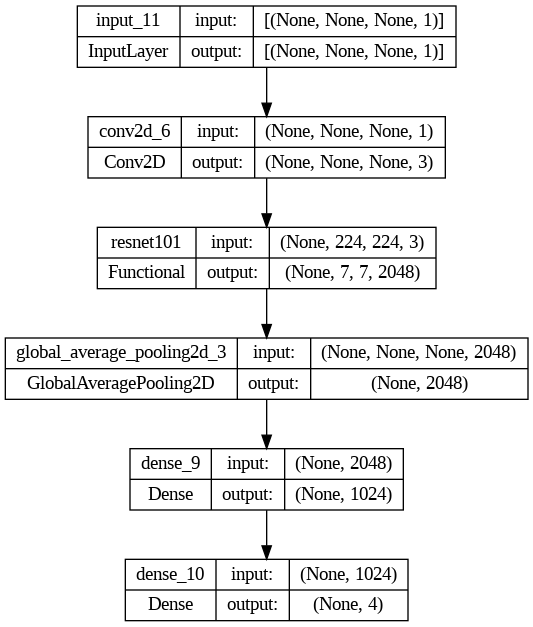

In [42]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [43]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [44]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 48s 888ms/step - loss: 1.0046 - accuracy: 0.6987 - val_loss: 0.4716 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 39s 833ms/step - loss: 0.4281 - accuracy: 0.8458 - val_loss: 0.4197 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 40s 841ms/step - loss: 0.3372 - accuracy: 0.8721 - val_loss: 0.3767 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 39s 837ms/step - loss: 0.2798 - accuracy: 0.8930 - val_loss: 0.3204 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 40s 839ms/step - loss: 0.2778 - accuracy: 0.8937 - val_loss: 0.3512 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 40s 840ms/step - loss: 0.2483 - accuracy: 0.9059 - val_loss: 0.4086 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 40s 839ms/st

ResNet101 Evaluation

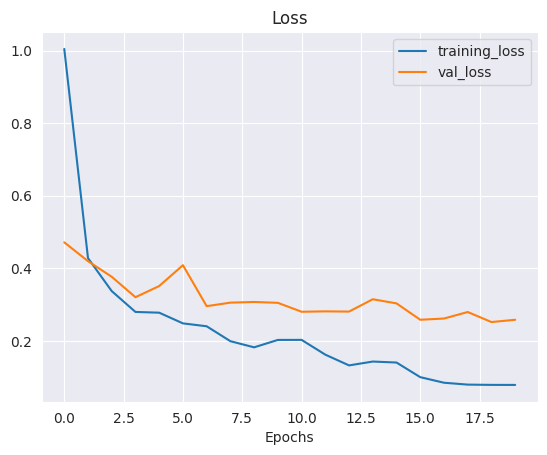

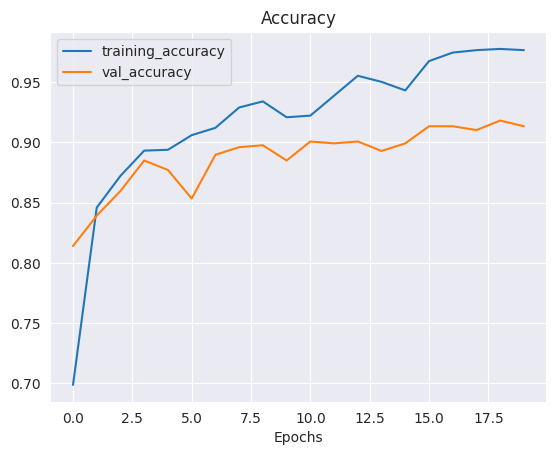

In [45]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 3s 303ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       158
           1       0.99      0.98      0.98       166
           2       0.85      0.76      0.80       154
           3       0.84      0.86      0.85       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.29554655870445345, 0.3389121338912134, 0.2237093690248566, 0.28]
Mean Squared Error: : 0.11127364635467529
The average AUC-ROC is 0.9793350183933787


[0.9743589743589743,
 0.6680672268907563,
 0.6958250497017893,
 0.6807610993657506,
 0.6474358974358975,
 0.9915966386554622,
 0.6739562624254473,
 0.6511627906976745,
 0.7072649572649573,
 0.6785714285714286,
 0.9264413518886679,
 0.7145877378435518,
 0.6709401709401709,
 0.6617647058823529,
 0.7037773359840954,
 0.9534883720930233]

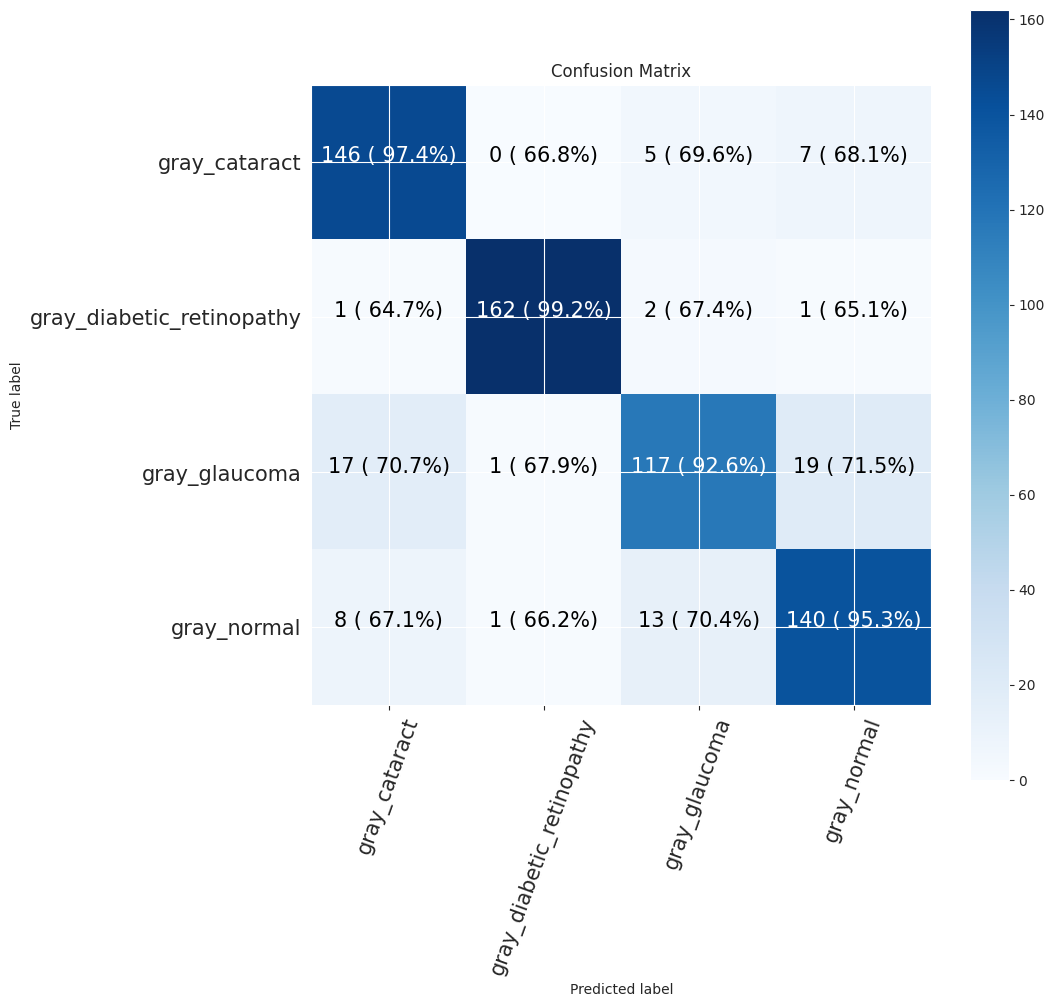

In [46]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


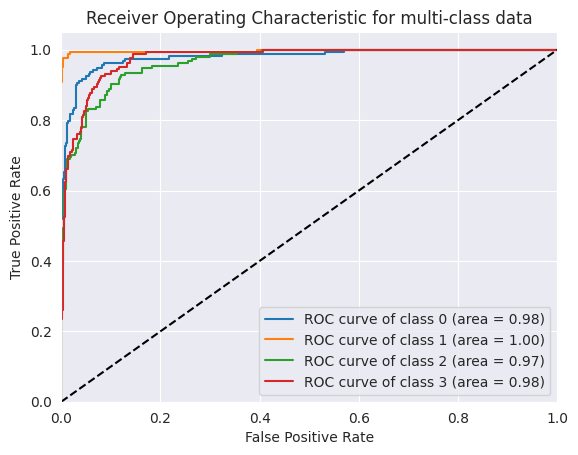

In [47]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()